# Predicting Chemical and Genetic Perturbations from Images 

In [72]:
from os import listdir
from os.path import join
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn

from PIL import Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import RidgeClassifier
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from torchvision.transforms import v2
from tqdm.notebook import tqdm
from umap import UMAP

In [19]:
class SegmentedImageDataset(Dataset):
    def __init__(self, image_dir: str, segmented_dir: str, metadata_path: str, image_transforms: Optional[v2.Compose], mask_transforms: Optional[v2.Compose], unified_transforms: Optional[v2.Compose]):
        metadata_df = pl.read_csv(metadata_path).with_columns(file_key=pl.col('FileName_OrigRNA').str.split('-').list.first().str.reverse().str.slice(3).str.reverse())

        self.metadata_dict = metadata_df.select('file_key', 'Metadata_pert_iname').to_pandas().set_index('file_key')['Metadata_pert_iname'].to_dict()
        self.target_dict = {tgt: torch.tensor(i, dtype=torch.int64) for i, tgt in enumerate(metadata_df.get_column('Metadata_pert_iname').unique())}
        
        self.image_dir = image_dir
        self.images = listdir(image_dir)
        self.segmented_dir = segmented_dir
        
        assert len(self.images) == len(listdir(segmented_dir))
        self.length = len(self.images)
        
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.unified_transforms = unified_transforms
        
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        img_file_name = self.images[index]
        img = Image.open(join(self.image_dir, img_file_name))
        img = img if self.image_transforms is None else self.image_transforms(img)
        
        seg = torch.tensor(np.load(join(self.segmented_dir, img_file_name + '.npy')).astype('int64')).unsqueeze(0)
        seg = seg if self.mask_transforms is None else self.mask_transforms(seg)
        
        out = torch.cat((seg, img))
        out = out if self.unified_transforms is None else self.unified_transforms(out)
        out = torch.prod(out, dim=0, keepdim=True).repeat(3, 1, 1)
        
        target = self.target_dict[self.metadata_dict[img_file_name.split('_')[0]]]
        
        return out, target
        
    def __len__(self) -> int:
        return self.length
    
    def n_classes(self) -> int:
        return len(self.target_dict)

In [20]:
BATCH_SIZE = 128

rng = torch.random.manual_seed(77)
dataset = SegmentedImageDataset(
    'Data/downsampled_data', 
    'Segmented', 
    'Data/metadata_BR00116991.csv', 
    v2.Compose([
        v2.ToImage(),
        v2.RandomVerticalFlip(),
        v2.RandomHorizontalFlip(),
        v2.RandomRotation(degrees=20),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    None,
    None
)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=rng)
train_loader, test_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True), DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
def extract_features(device, dataloader, classifier):
    features = []
    labels = []
    classifier.eval()
    with torch.no_grad():
        for images, label in tqdm(dataloader):
            embeddings = classifier(images.to(device))
            embeddings = embeddings.view(embeddings.size(0), -1)
            
            features.append(embeddings.cpu())
            labels.extend(label)

    return torch.cat(features, dim=0).cpu(), torch.Tensor(labels).unsqueeze(1).cpu()


In [22]:
def train_loop(device, classifier, train_loader, optimizer, scheduler, loss_fn, n_epochs):
    losses, accs = [], []
    classifier.train()
    iters = len(train_loader)
    for epoch in range(1, 1+n_epochs):
        loss_val = 0
        acc_val = 0
        n = 0
        for i, (X, y) in tqdm(enumerate(train_loader), total=iters):
            m = y.size(0)
    
            X, y = X.to(device), y.to(device)
            yhat = classifier(X)
            pred = torch.argmax(yhat, dim=1)
            
            loss = loss_fn(yhat, y)
            acc = (pred == y).sum()
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            
            loss_val += loss.item() * m
            acc_val += acc.item()
            n += m
        
        print(f'Epoch {epoch}: Loss = {loss_val / n:.3f}; Accuracy = {acc_val / n:.3f}; LR = {scheduler.get_last_lr()[0]}')
        losses.append(loss_val / n)
        accs.append(acc_val / n)
        
    
    return np.array(losses), np.array(accs)


In [23]:
def test_loop(device, classifier, test_loader, loss_fn) -> Tuple[float, float]:
    classifier.eval()
    loss_val = 0
    acc_val = 0
    n = 0
    with torch.no_grad():
        for (X, y) in tqdm(test_loader):
            m = y.size(0)
    
            X, y = X.to(device), y.to(device)
            yhat = classifier(X)
            pred = torch.argmax(yhat, dim=1)
            
            loss = loss_fn(yhat, y)
            acc = (pred == y).sum()
                       
            loss_val += loss.item() * m
            acc_val += acc.item()
            n += m
    
    return loss_val / n, acc_val / n


Example Mask


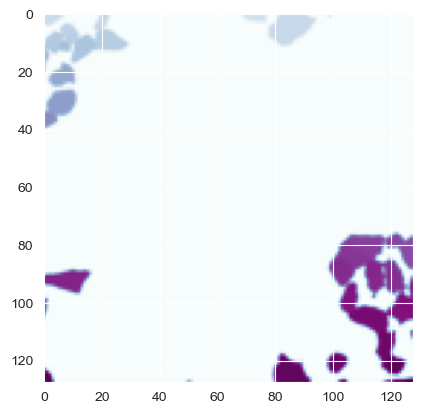

Example Image


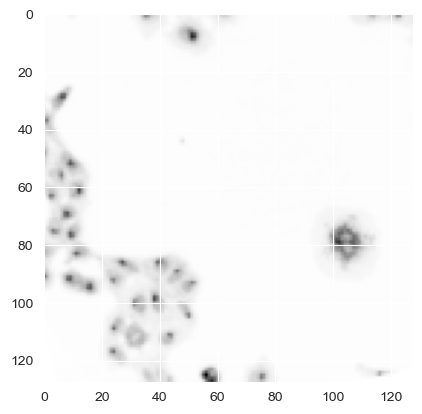

Example Masked Image


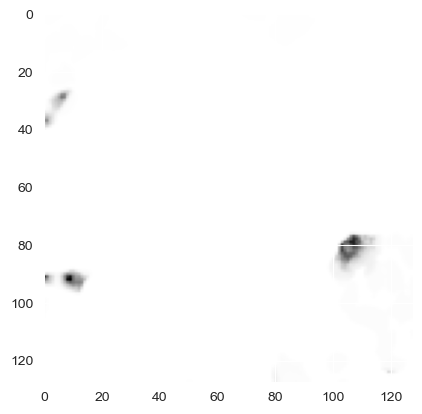

In [18]:
samp = next(iter(train_loader))[0][0]

_ = plt.imshow(samp[0], cmap='BuPu')
print('Example Mask')
plt.show()

_ = plt.imshow(samp[1], cmap='Grays')
print('Example Image')
plt.show()

plt.imshow(torch.prod(samp, dim=0, keepdim=True)[0], cmap='Grays')
print('Example Masked Image')
plt.show()

In [ ]:
device = torch.device('mps')
OUTPUT_DIR = 'Outputs'
res = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT).to(device)
encoder = nn.Sequential(*list(res.children())[:-1])

train_features, train_labels = extract_features(device, train_loader, encoder)
test_features, test_labels = extract_features(device, train_loader, encoder)

torch.save(train_features, join(OUTPUT_DIR, 'train_features.pt'))
torch.save(train_labels, join(OUTPUT_DIR, 'train_labels.pt'))
torch.save(test_features, join(OUTPUT_DIR, 'test_features.pt'))
torch.save(test_labels, join(OUTPUT_DIR, 'test_labels.pt'))

In [73]:
train_features = torch.load(join(OUTPUT_DIR, 'train_features.pt'))
train_labels = torch.load(join(OUTPUT_DIR, 'train_labels.pt'))
test_features = torch.load(join(OUTPUT_DIR, 'test_features.pt'))
test_labels = torch.load(join(OUTPUT_DIR, 'test_labels.pt'))

<Axes: >

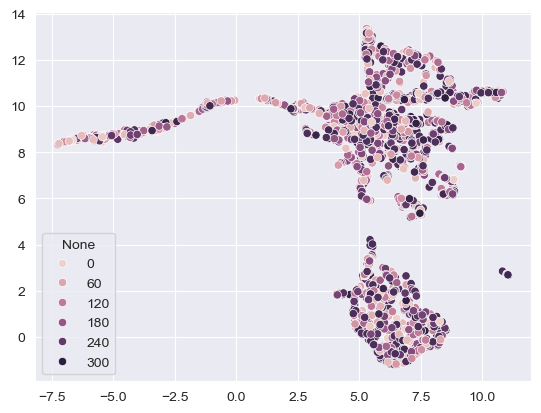

In [27]:
umap = UMAP()
umap_embed = umap.fit_transform(train_features)
sns.scatterplot(x=umap_embed[:, 0], y=umap_embed[:, 1], hue=train_labels.flatten())

<Axes: >

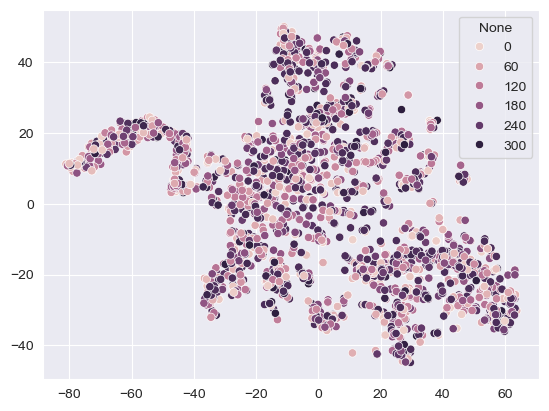

In [28]:
tsne = TSNE()
tsne_embed = tsne.fit_transform(train_features)
sns.scatterplot(x=tsne_embed[:, 0], y=tsne_embed[:, 1], hue=train_labels.flatten())

In [78]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

In [74]:
clf = RandomForestClassifier()
clf = clf.fit(train_features, train_labels.flatten())
print(metrics.accuracy_score(train_labels.flatten(), clf.predict(train_features)))
print(metrics.accuracy_score(test_labels.flatten(), clf.predict(test_features)))

1.0
0.18150087260034903


In [76]:
clf = BernoulliNB()
clf = clf.fit(train_features, train_labels.flatten())
print(metrics.accuracy_score(train_labels.flatten(), clf.predict(train_features)))
print(metrics.accuracy_score(test_labels.flatten(), clf.predict(test_features)))

0.3055797733217088
0.16404886561954624


In [79]:
clf = GaussianNB()
clf = clf.fit(train_features, train_labels.flatten())
print(metrics.accuracy_score(train_labels.flatten(), clf.predict(train_features)))
print(metrics.accuracy_score(test_labels.flatten(), clf.predict(test_features)))

0.44463818657367044
0.06631762652705062


In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [82]:
clf = KNeighborsClassifier()
clf = clf.fit(train_features, train_labels.flatten())
print(metrics.accuracy_score(train_labels.flatten(), clf.predict(train_features)))
print(metrics.accuracy_score(test_labels.flatten(), clf.predict(test_features)))

0.2855274629468178
0.04363001745200698


In [83]:
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV

In [84]:
clf = LogisticRegression()
clf = clf.fit(train_features, train_labels.flatten())
print(metrics.accuracy_score(train_labels.flatten(), clf.predict(train_features)))
print(metrics.accuracy_score(test_labels.flatten(), clf.predict(test_features)))

0.6887532693984307
0.06108202443280977


/opt/miniconda3/envs/stat4243/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
clf = RidgeClassifierCV(alphas=(0.05, 0.1, 0.5, 1, 5))
clf = clf.fit(train_features, train_labels.flatten())
print(metrics.accuracy_score(train_labels.flatten(), clf.predict(train_features)))
print(metrics.accuracy_score(test_labels.flatten(), clf.predict(test_features)))

0.7410636442894507
0.07853403141361257
